In [1]:
%matplotlib notebook

import mne
from os.path import join
import pandas as pd
import numpy as np
from tqdm.notebook import trange


data_folder = join(join('..', 'data'), 'congedo')

In [2]:
demographics = pd.read_csv(join(data_folder, 'demographic.csv'),
                           header=None,
                           names=pd.read_csv(join(data_folder, 'demographic_header.csv')).columns
                          )
demographics.set_index('Subject', inplace=True)
demographics['IsMan'] = demographics.IsMan.astype(bool)
demographics['Gender'] = demographics.IsMan.apply(lambda x: 'Man' if x else 'Woman')
demographics.head()

,IsMan,Age,Fatigue,Gender
Subject,,,,
1,True,27,5,Man
2,True,23,0,Man
3,True,44,2,Man
4,True,26,2,Man
5,True,26,4,Man


In [94]:
def extract_covs(subject):
    head = pd.read_csv(join(data_folder, 'header.csv')).columns
    data = pd.read_csv(join(data_folder, "subject_{:02}.csv".format(subject)),
                            header=None,
                            names=head).set_index('Time')

    S = data.iloc[:, :16].to_numpy()
    stim = (1 * data.EyesClosed + 2 * data.EyesOpened).to_numpy()

    chnames = ['Fp1',
               'Fp2',
               'FC5',
               'Fz',
               'FC6',
               'T7',
               'Cz',
               'T8',
               'P7',
               'P3',
               'Pz',
               'P4',
               'P8',
               'O1',
               'Oz',
               'O2',
               'stim'
              ]
    chtypes = ['eeg'] * 16 + ['stim']

    X = np.concatenate([S, np.expand_dims(stim, -1)], axis=1).T
    info = mne.create_info(ch_names=chnames, sfreq=512, ch_types=chtypes, verbose=False)
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(data=X, info=info, verbose=False)

    events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
    event_id = {'closed':1, 'open':2}
    epochs = mne.Epochs(raw, events, event_id,
                        tmin=2.0, tmax=8.0,
                        baseline=(None, None), 
                        verbose=False, preload=True)
    
    epochs.pick_types(eeg=True)

    cova_open = mne.compute_covariance(epochs['open'],
                                   #method='ledoit_wolf',
                                   scalings={'eeg':1e6},
                                   verbose=False,
                                  )
    cova_clos = mne.compute_covariance(epochs['closed'],
                                   #method='ledoit_wolf',
                                   scalings={'eeg':1e6},
                                   verbose=False,
                                  )

    #X = epochs.get_data()
    #X = (X - np.expand_dims(X.mean(axis=-1), -1)) / np.expand_dims(X.std(axis=-1), -1)
    #covs = np.einsum('...ij,...kj', X, X) / X.shape[-1]
    
    covs = np.concatenate([np.expand_dims(cova_open['data'] / cova_open.nfree, 0),
                           np.expand_dims(cova_clos['data'] / cova_clos.nfree, 0)], axis=0)
    
    y = events[:, -1]

    return covs, y

<IPython.core.display.Javascript object>


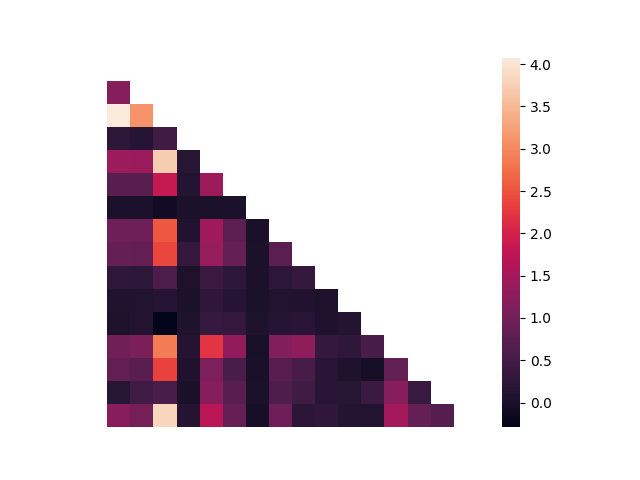

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

c, y = extract_covs(1)
#print(c)
mask = np.zeros(shape=(16,16))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=c[0], 
            mask=mask,
            square=True,
            yticklabels=False,
            xticklabels=False
           )
plt.show()

#plt.plot(range(16), np.linalg.eigvalsh(c)[1])
#plt.show()

In [13]:
covs = []
labels = []
ages = []


for i in trange(20):
    subject = i + 1
    #print('Reading subject {:02}...'.format(subject))
    c, y = extract_covs(subject)
    covs.append(c)
    labels += list(y)
    ages += [float(demographics.loc[subject, 'Age'])] * len(y)

covs = np.concatenate(covs, axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
covs.shape[1:]

(16, 16)